In [1]:
import pandas as pd
import numpy as np
from pprint import pprint

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline

In [2]:
import matplotlib.font_manager

In [3]:
#matplotlib.rcParams['font.family'] = 'Times New Roman'

In [4]:
df = pd.read_excel('svea_data.xlsx', 'ALLT (med tomma dagar sist)')

In [5]:
print(f'data has {len(df.index)} rows')

data has 9811 rows


### Filter irrelevant columns

Droppa:

`Passage no, TIME, IMG_NO, Camera, AGE (A/yA/C), samt ALLA
VÄDERKOLUMNER!`

In [6]:
irr_cols = ['Passage no', 'TIME', 'IMG_NO', 'Camera', 'AGE (A/yA/C)',
            'Temp Cam [C]', 'Temp [C]', 'Preasure [Pa]', 'Humidity',
            'Wind speed', 'Cloud coverage', 'Temp Avg [C]',
            'Preasure Avg [Pa]','Humidity Avg','Wind speed Avg',
            'Cloud coverage Avg', 'Unnamed: 26']

In [7]:
df = df[[col for col in df.columns if col not in irr_cols]]

In [8]:
df = df.rename(str.lower, axis='columns')

In [9]:
df.head(1)

,date,hour,corridor,camera,sex (m/f/u),direction (in/out/along/u),dir (num),group size,passage (1/0/*),luminosity,moon phase
0,2015-06-29,9,2,a,NaN,unknown,NaN,1,1,0.939784,4


In [10]:
df = df.rename(index=str, columns={
    'sex (m/f/u)': 'sex',
    'direction (in/out/along/u)': 'direction',
    'dir (num)': 'direction_numerical',
    'passage (1/0/*)': 'passage'
})

In [11]:
df.head(1)

,date,hour,corridor,camera,sex,direction,direction_numerical,group size,passage,luminosity,moon phase
0,2015-06-29,9,2,a,NaN,unknown,NaN,1,1,0.939784,4


In [12]:
palette = sns.color_palette('Paired')

In [13]:
p = sns.color_palette("Paired", 8)

# Passages per direction

#### Total number of passages per direction.
Dvs. Hur stor andel av alla passager, Passage (1/0/*) = 1 , har skett i respektive riktning
in/out/along/unknown?

In [14]:
df.direction.unique()

array(['unknown', 'out', 'in', 'along', 'along (wi)', 'along (wo)',
       ' out', 'along ', 0], dtype=object)

In [15]:
# fix misspelled data
df.loc[df.direction == ' out', 'direction'] = 'out'
df.loc[df.direction == 'along ', 'direction'] = 'along'
df.loc[df.direction == 'along (wi)','direction'] = 'along'
df.loc[df.direction == 'along (wo)', 'direction'] = 'along'

In [16]:
df.direction.unique()

array(['unknown', 'out', 'in', 'along', 0], dtype=object)

In [17]:
matplotlib.style.use('seaborn-deep')
matplotlib.rcParams.update({'font.size': 22})

Text(0.5, 0, 'Direction')

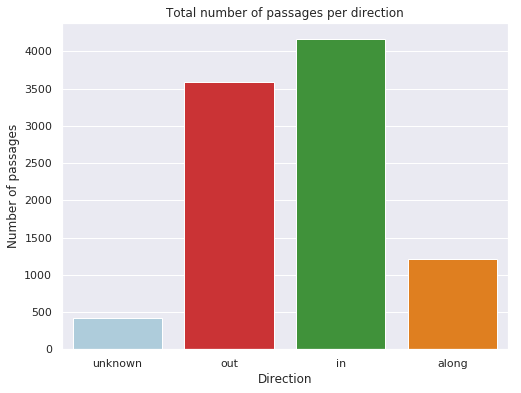

In [18]:
fig, ax = plt.subplots(1, figsize=(8,6))
sns.countplot(x='direction', 
              data=df[df.passage == 1],
              palette=[p[0], p[5], p[3], p[7]],
              ax=ax)
ax.set_title('Total number of passages per direction')
ax.set_ylabel('Number of passages')
ax.set_xlabel('Direction')

#### Total number of true passages per direction.
Dvs. hur stor andel av alla passager, Passage (1/0/*) = 1, som har skett i riktningarna in och
out, DIR (NUM) = 1 resp 0, har skett i respektive riktning.

Text(0.5, 0, 'Direction')

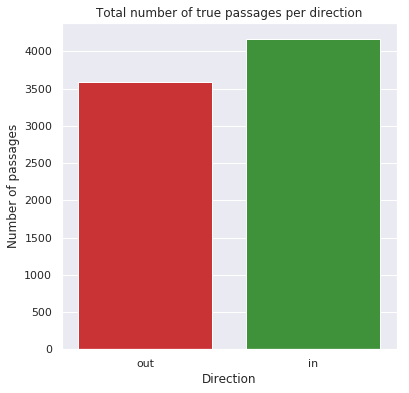

In [19]:
fig, ax = plt.subplots(1, figsize=(6,6))
sns.countplot(x='direction', 
              data=df[
                  (df.passage == 1) &
                  (
                      (df.direction_numerical == 1) |
                      (df.direction_numerical == 0)
                  )
              ],
              palette=[p[5], p[3]],
              ax=ax)
ax.set_title('Total number of true passages per direction')
ax.set_ylabel('Number of passages')
ax.set_xlabel('Direction')

OBS: Denna plot är typiskt intetsägande - idén med plots är ju att kunna skapa en intuitiv framställning av data som gör att man får en "känsla" för hur saker ligger till. Detta kan likagärna presenteras i text:

In [20]:
len_all = len(df[(df.passage == 1) & ((df.direction_numerical == 1) |
                                  (df.direction_numerical == 0))].index)
len_in = len(df[(df.passage == 1) & (df.direction_numerical == 1)].index)
print(f'all passages count: {len_all}')
print(f'passages going in: {len_in}')
print(f'fraction going in: {len_in/len_all}%')

all passages count: 7759
passages going in: 4169
fraction going in: 0.5373115092151051%


##### "Out of all the 7759 passages where elephants went either in or out, 4169 (0.54%) passages were made in the inward direction" 

### Passager per timme på dygnet.

#### Total number of passages by hour of day.
Dvs. Av alla passager i alla riktningar, hur är dessa fördelade över dygnets olika timmar.

In [21]:
hour_by_dir = df[df.passage == 1]\
                 .groupby(['hour', 'direction'])\
                 .count().reset_index()
hour_by_dir.head(5)

,hour,direction,date,corridor,camera,sex,direction_numerical,group size,passage,luminosity,moon phase
0,0,along,31,31,31,19,0,31,31,31,31
1,0,in,132,132,132,87,132,132,132,132,132
2,0,out,141,141,141,105,141,141,141,141,141
3,0,unknown,10,10,10,5,0,10,10,10,10
4,1,along,17,17,17,16,0,17,17,17,17


In [22]:
# sanity check, passages at `along` in hour 0 should be = 31
len(df[(df.passage == 1) & (df.hour == 0) & (df.direction == 'along')].index)

31

Text(0.5, 0, 'Hour')

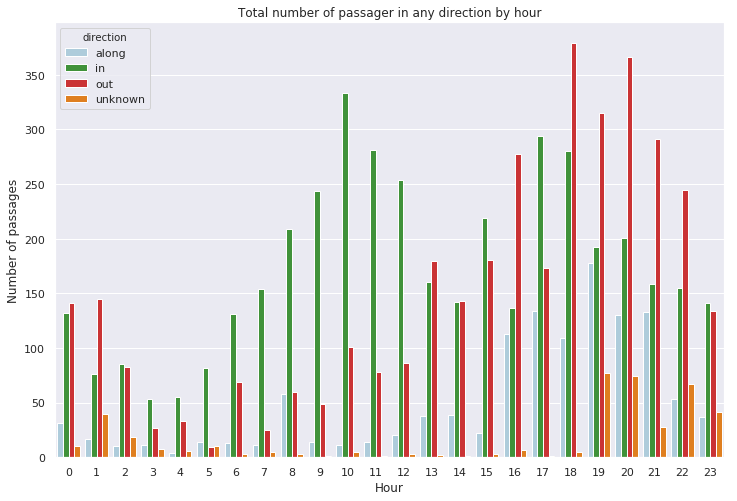

In [23]:
fig, ax = plt.subplots(1, figsize=(12,8))
sns.barplot(x='hour', 
            y='date', 
            hue='direction', 
            data=hour_by_dir,
            palette=[p[0], p[3], p[5], p[7]],
            ax=ax)
ax.set_title('Total number of passager (any direction) by hour')
ax.set_ylabel('Number of passages')
ax.set_xlabel('Hour')

### Same plot as lineplot

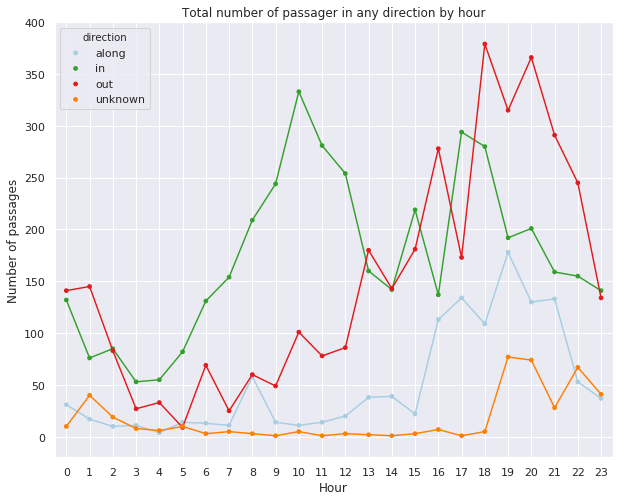

In [24]:
fig, ax = plt.subplots(1, figsize=(10,8))
sns.set_context(rc={"lines.linewidth": 0.8})
sns.pointplot(x='hour', 
              y='date', 
              hue='direction', 
              data=hour_by_dir,
              palette=[p[0], p[3], p[5], p[7]],
              linewidth=0.2, 
              markersize=20,
              ax=ax)
ax.set_title('Total number of passager (any direction) by hour')
ax.set_ylabel('Number of passages')
ax.set_xlabel('Hour')
ax.grid(True)

#### Total number of true passages by hour of day.
Dvs. Samma som ovan men endast för de passager som skett in resp out

In [25]:
true_by_dir = df[(df.passage == 1) & 
                 ((df.direction_numerical == 1) |
                  (df.direction_numerical == 0))]\
                 .groupby(['hour', 'direction'])\
                 .count().reset_index()
true_by_dir.head(5)

,hour,direction,date,corridor,camera,sex,direction_numerical,group size,passage,luminosity,moon phase
0,0,in,132,132,132,87,132,132,132,132,132
1,0,out,141,141,141,105,141,141,141,141,141
2,1,in,76,76,76,58,76,76,76,76,76
3,1,out,145,145,145,107,145,145,145,145,145
4,2,in,85,85,85,60,85,85,85,85,85


Text(0.5, 0, 'Hour')

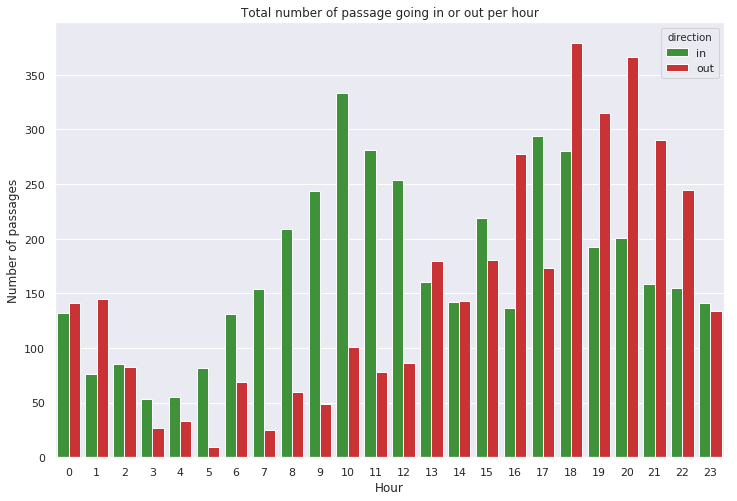

In [26]:
fig, ax = plt.subplots(1, figsize=(12,8))
sns.barplot(x='hour', 
            y='date', 
            hue='direction', 
            data=true_by_dir,
            palette=[p[3], p[5]],
            ax=ax)
ax.set_title('Total number of passages (in/out) per hour')
ax.set_ylabel('Number of passages (in/out)')
ax.set_xlabel('Hour')

### Same plot as lineplot

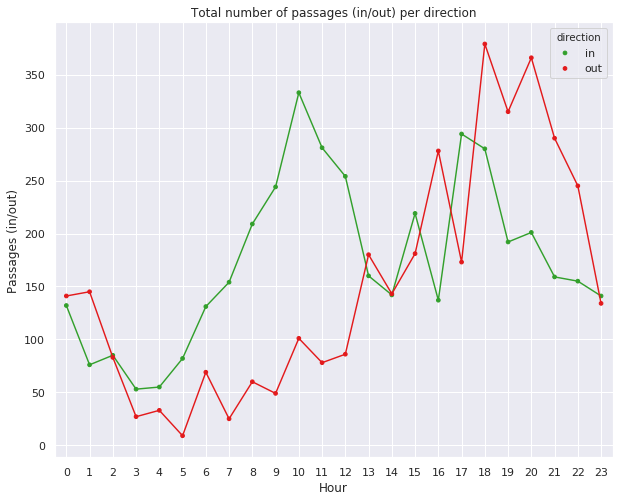

In [27]:
fig, ax = plt.subplots(1, figsize=(10,8))
sns.set_context(rc={"lines.linewidth": 0.8})
sns.pointplot(x='hour', 
              y='date', 
              hue='direction', 
              data=true_by_dir,
              palette=[p[3], p[5]],
              ax=ax)
ax.set_title('Total number of passages (in/out) per direction')
ax.set_ylabel('Passages (in/out)')
ax.set_xlabel('Hour')
ax.grid(True)

### Percentage of total number of passages taking place during day versus night.
Dvs. Av alla passager i alla riktningar, hur stor andel sker mellan kl 07:00 tom 19:00 resp
mellan 19:00 tom 07:00.

In [28]:
by_day = df[(df.passage == 1) & ((df.hour >= 7) & (df.hour <= 19))]
by_night = df[(df.passage == 1) & (~df.index.isin(by_day.index))]
all_times = df[df.passage == 1]

In [29]:
# sanity check
print(f'hours in by_day: {sorted(by_day.hour.unique())}')
print(f'hours in by_night: {sorted(by_night.hour.unique())}')

hours in by_day: [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
hours in by_night: [0, 1, 2, 3, 4, 5, 6, 20, 21, 22, 23]


In [30]:
print('Percentage of passages by day {:.2f}%'
      .format(len(by_day.index) / len(all_times.index)))
      
print('Percentage of passages by night {:.2f}%'
      .format(len(by_night.index) / len(all_times.index)))

Percentage of passages by day 0.62%
Percentage of passages by night 0.38%


### Percentage of total number of true passages taking place during day versus night.

Dvs. Samma som ovan men endast för de passager som skett in resp out.

In [31]:
true = df[(df.passage == 1) & ((df.direction_numerical == 1) |
                               (df.direction_numerical == 0))]

In [32]:
true_by_day = true[(true.passage == 1) & 
              ((true.hour >= 7) & (true.hour <= 19))]

true_by_night = true[(true.passage == 1) & 
                     (~true.index.isin(true_by_day.index))]

In [33]:
# sanity check
print(f'hours in true_by_day: {sorted(true_by_day.hour.unique())}')
print(f'hours in true_by_night: {sorted(true_by_night.hour.unique())}')

hours in true_by_day: [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
hours in true_by_night: [0, 1, 2, 3, 4, 5, 6, 20, 21, 22, 23]


In [34]:
print('Percentage of true passages by day {:.2f}%'
      .format(len(true_by_day.index) / len(true.index)))
      
print('Percentage of true passages by night {:.2f}%'
      .format(len(true_by_night.index) / len(true.index)))

Percentage of true passages by day 0.64%
Percentage of true passages by night 0.36%


### Time of in passages.

Dvs. hur är passagerna `in` fördelade på tid på dygnet.

In [35]:
in_pass = df[(df.passage == 1) & (df.direction == 'in')]
in_pass_grouped = in_pass.groupby(['hour', 'direction'])\
                                    .count().reset_index()

Text(0.5, 0, 'Hour')

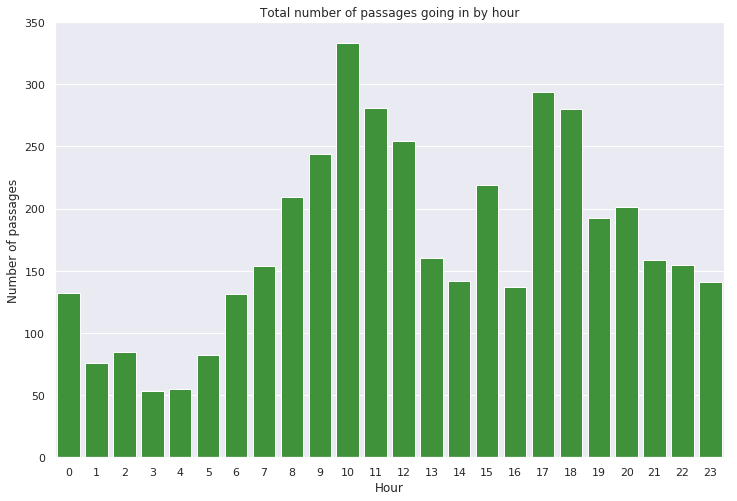

In [36]:
fig, ax = plt.subplots(1, figsize=(12,8))
sns.barplot(x='hour', 
            y='date', 
            data=in_pass_grouped,
            palette=[p[3]],
            ax=ax)
ax.set_title('Total number of passages going in by hour')
ax.set_ylabel('Number of passages')
ax.set_xlabel('Hour')

### Same plot as lineplot

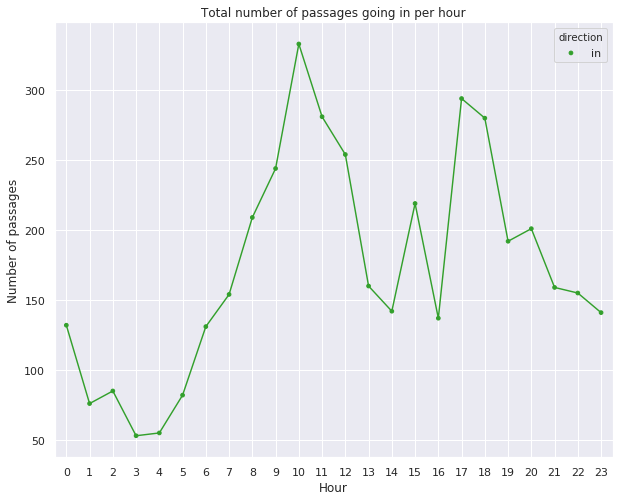

In [37]:
fig, ax = plt.subplots(1, figsize=(10,8))
sns.set_context(rc={"lines.linewidth": 0.8})
sns.pointplot(x='hour', 
              y='date', 
              hue='direction',
              data=in_pass_grouped,
              palette=[p[3]],
              ax=ax)
ax.set_title('Total number of passages going in per hour')
ax.set_ylabel('Number of passages')
ax.set_xlabel('Hour')
ax.grid(True)

### Time of out passages.
Dvs. hur är passagerna in fördelade på tid på dygnet.

In [38]:
out_pass = df[(df.passage == 1) & (df.direction == 'out')]
out_pass_grouped = out_pass.groupby(['hour', 'direction'])\
                                    .count().reset_index()

Text(0.5, 0, 'Hour')

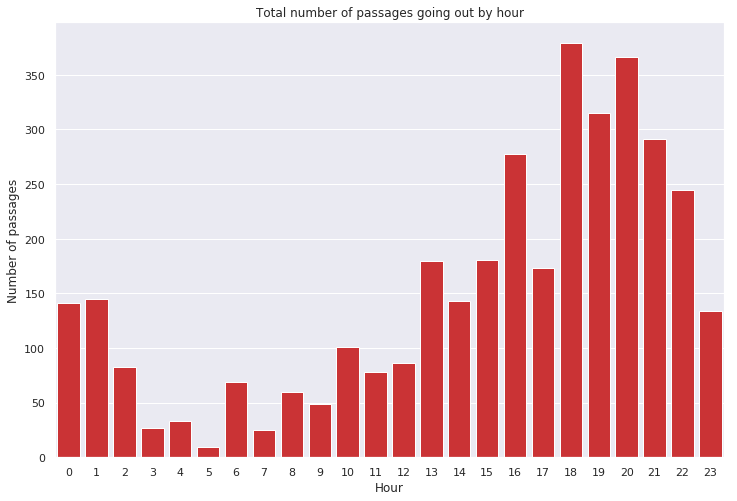

In [39]:
fig, ax = plt.subplots(1, figsize=(12,8))
sns.barplot(x='hour', 
            y='date', 
            data=out_pass_grouped,
            palette=[p[5]],
            ax=ax)
ax.set_title('Total number of passages going out by hour')
ax.set_ylabel('Number of passages')
ax.set_xlabel('Hour')

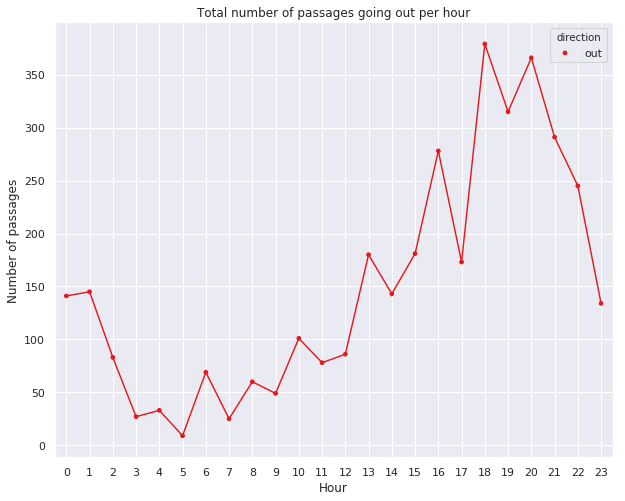

In [40]:
fig, ax = plt.subplots(1, figsize=(10,8))
sns.set_context(rc={"lines.linewidth": 0.8})
sns.pointplot(x='hour', 
              y='date', 
              hue='direction',
              data=out_pass_grouped,
              palette=[p[5]],
              ax=ax)
ax.set_title('Total number of passages going out per hour')
ax.set_ylabel('Number of passages')
ax.set_xlabel('Hour')
ax.grid(True)

OBS: Båda dessa plots med passages in/out har redan visats i tidigare plots, båda i de som täcker alla directions och de som bara visar in/out. Överflödiga att ha med förmodligen. Kanske vill du ha de side-by-side för någon diskussion dock, men ändå konstigt att visa samma sak flera gånger. Kan visas i samm grid nedan:

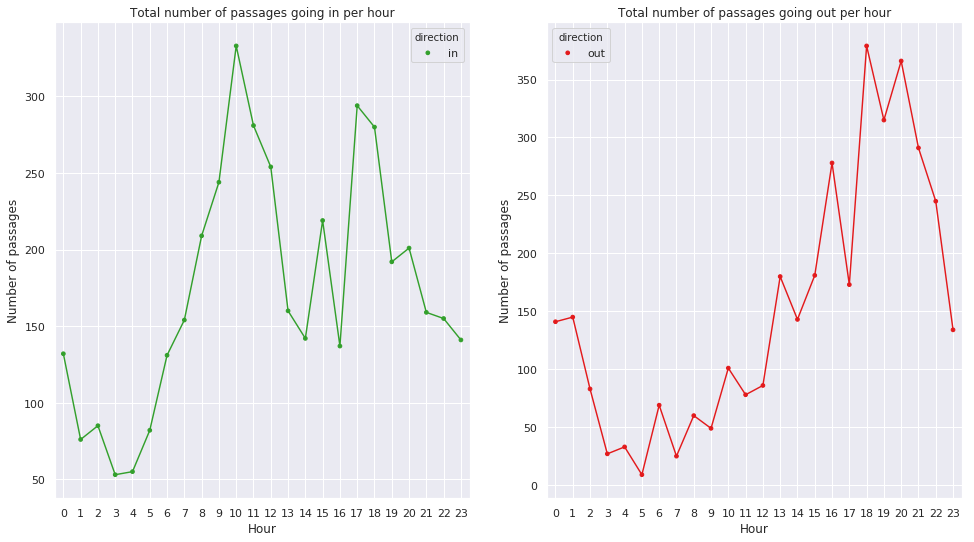

In [41]:
fig, axes = plt.subplots(1,2, figsize=(14,8))
axes = axes.flatten()

sns.set_context(rc={"lines.linewidth": 0.8})
sns.pointplot(x='hour', 
              y='date', 
              hue='direction',
              data=in_pass_grouped,
              palette=[p[3]],
              ax=axes[0])
axes[0].set_title('Total number of passages going in per hour')
axes[0].set_ylabel('Number of passages')
axes[0].set_xlabel('Hour')
axes[0].grid(True)

sns.set_context(rc={"lines.linewidth": 0.8})
sns.pointplot(x='hour', 
              y='date', 
              hue='direction',
              data=out_pass_grouped,
              palette=[p[5]],
              ax=axes[1])
axes[1].set_title('Total number of passages going out per hour')
axes[1].set_ylabel('Number of passages')
axes[1].set_xlabel('Hour')
axes[1].grid(True)

plt.tight_layout()
plt.show()

### Genomsnittsantal passager per dag fördelat på kalendermånader 
(alla tre åren tillsammans plus var och en för sig).

In [42]:
df['year_month'] = df['date'].apply(lambda t: t.strftime('%Y-%m'))
df['month_day'] = df['date'].apply(lambda t: t.strftime('%m-%d'))
df['month'] = df['date'].apply(lambda t: t.strftime('%m'))
df['day'] = df['date'].apply(lambda t: t.strftime('%d'))

### Vi kan börja med mean passages per month, med err-bars för konfidensintervall .95.

Förklaring av konfidensintervall:

För "mean" estimatorn (medelvärdet) räknas konfidensintervallet ut som:

$\bar{x} \pm 1.96\sigma / \sqrt{n}$

Där $ n $ är antalet observationer i ditt sample och $\sigma$ är standardavvikelsen. Det du uppskattar är alltså osäkerheten av medelvärdet _i populationen_ (dvs alla värden som kan tänkas finnas, inte bara de du har att jobba med) givet ditt sample. Som du ser är det beroende av spridningen ($\sigma$) och hur många observationer du har ($n$). Om du har stor spridning, ja då blir $\sigma$ stort och osäkerheten på din uppskattning av medelvärdet större. På samma sätt blir din osäkerhet mindre ju fler observationer du har ($\sqrt{n}$ blir större), och din osäkerhet minskar, eftersom vi delar $1.96\sigma $ med $\sqrt{n}$.

Värdet $1.96$ kommer från att vi därmed täcker 95% av sannolikhetsfördelningen (vi är 95% säkra på att det sanna medelvärden ligger någonstans plus/minus $1.96\sigma / \sqrt{n}$ från vårt uppskattade medelvärde $\bar{x}$.

En förutsättning för att detta ska funka är att datan är normalfördelad, vilket du kan anta att den är vid ett stort antal observationer tack vare [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem).

#### Start by taking mean of each month, all years, as barplot with CI=0.95

In [43]:
# drop passage == '*' vi kan inte summera '*', måste vara siffror
df_drop = df[df.passage != '*']
df_drop.loc[:, 'passage'] = df_drop['passage'].astype(int)

/home/max/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [44]:
month_sum = df_drop.groupby('date').sum().reset_index()
month_sum['year'] = month_sum['date'].apply(lambda t: t.strftime('%Y'))
month_sum['month'] = month_sum['date'].apply(lambda t: t.strftime('%m'))
month_sum['year_month'] = month_sum['date'].apply(lambda t: t.strftime('%Y-%m'))

Nu har vi alltså summerat alla passager för varje datum, sen tar vi medelvärdet av alla dags-summor för varje månad. De svarta sträcken representerar .95 konfidensintervallets övre och undre gräns (dvs vi är 95% säkra på att det sanna medelvärdet ligger någonstans mellan dessa de svarta sträcken).

/home/max/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Mean passages (any direction) per day in months')

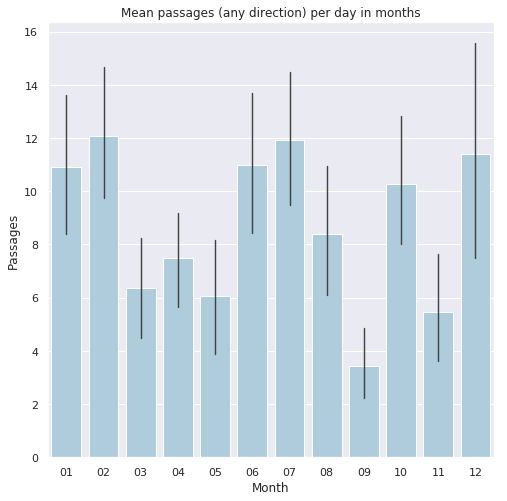

In [45]:
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(x='month', 
            y='passage', 
            data=month_sum,
            ci=95, 
            palette=[palette[0]])
ax.set_xlabel('Month')
ax.set_ylabel('Passages')
ax.set_title('Mean passages (any direction) per day in months')

Johanna föredrog proper names för månaderna istället för siffror, kanske ser bättre ut?

In [46]:
month_names = {
    '01': 'January',
    '02': 'February',
    '03': 'March',
    '04': 'April',
    '05': 'May',
    '06': 'June',
    '07': 'July',
    '08': 'August',
    '09': 'September',
    '10': 'October',
    '11': 'November',
    '12': 'December'
}

In [47]:
month_sum['proper_month'] = pd.Series()
for k,v in month_names.items():
    month_sum.loc[month_sum['month'] == k, 'proper_month'] = v

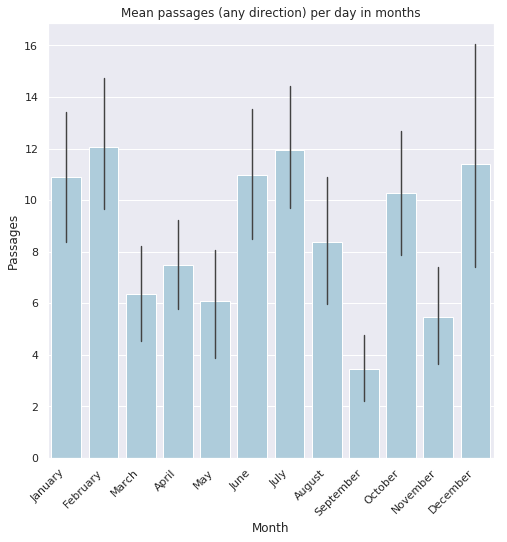

In [48]:
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(x='proper_month', 
            y='passage', 
            data=month_sum.sort_values(by='month'),
            ci=95, 
            palette=[palette[0]])
ax.set_xlabel('Month')
ax.set_ylabel('Passages')
ax.set_title('Mean passages (any direction) per day in months')
labels = ax.xaxis.get_majorticklabels() 
_=ax.set_xticklabels(labels, rotation=45, ha='right', minor=False)

### Split by year

In [49]:
month_sum.year.unique()

array(['2015', '2016', '2017', '2018'], dtype=object)

In [50]:
year_dfs = [
    month_sum[month_sum.year == '2015'],
    month_sum[month_sum.year == '2016'],
    month_sum[month_sum.year == '2017'],
    month_sum[month_sum.year == '2018']
]

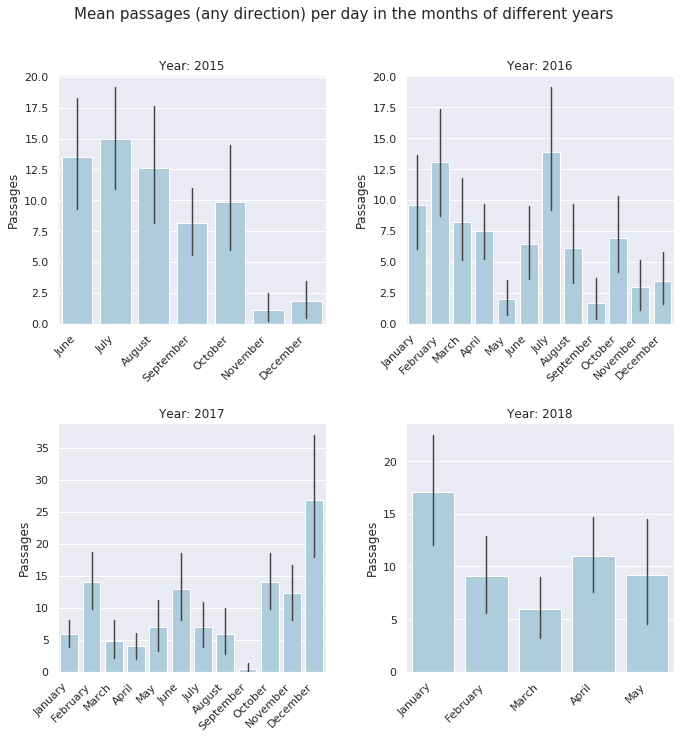

In [51]:
fig, axes = plt.subplots(2,2, figsize=(10,10))
axes = axes.flatten()
fig.suptitle(
    'Mean passages (any direction) per day in the months of different years',
    fontsize=15,
    y=1.04
)
for ax, y_df in zip(axes, year_dfs):
    sns.barplot(x='proper_month', 
            y='passage', 
            data=y_df.sort_values(by='month'),
            ci=95, 
            palette=[palette[0]],
            ax=ax)
    this_year = y_df['year'].unique()[0]
    ax.set_xlabel('')
    ax.set_ylabel('Passages')
    ax.set_title(
        f'Year: {this_year}')
    labels = ax.xaxis.get_majorticklabels() 
    ax.set_xticklabels(labels, rotation=45, ha='right', minor=False)
    #ax.xaxis.set_tick_params(rotation=45)

plt.tight_layout()

### Mean number of true passages taking place per day by month of the year.

Så gör vi allt igen bara för "true" passages..

In [52]:
df_only_true = df_drop[
    (df_drop.direction == 'in') |
    (df_drop.direction == 'out')
]

In [53]:
month_sum_true = df_only_true.groupby('date').sum().reset_index()
month_sum_true['year'] = month_sum_true['date'].apply(lambda t: t.strftime('%Y'))
month_sum_true['month'] = month_sum_true['date'].apply(lambda t: t.strftime('%m'))
month_sum_true['year_month'] = month_sum_true['date'].apply(lambda t: t.strftime('%Y-%m'))

Text(0.5, 1.0, 'Mean passages (in/out) per day in months')

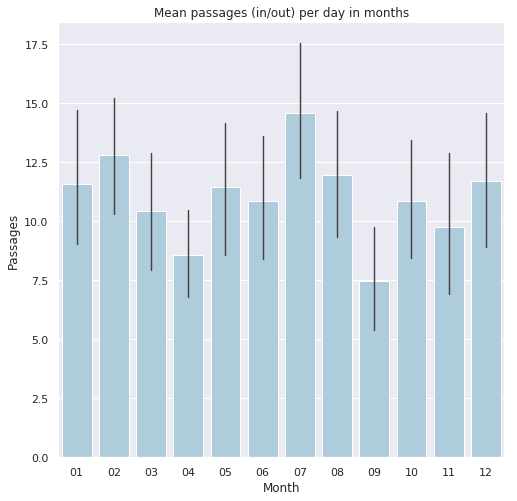

In [54]:
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(x='month', 
            y='passage', 
            data=month_sum_true,
            ci=95, 
            palette=[palette[0]])
ax.set_xlabel('Month')
ax.set_ylabel('Passages')
ax.set_title('Mean passages (in/out) per day in months')

In [55]:
month_names = {
    '01': 'January',
    '02': 'February',
    '03': 'March',
    '04': 'April',
    '05': 'May',
    '06': 'June',
    '07': 'July',
    '08': 'August',
    '09': 'September',
    '10': 'October',
    '11': 'November',
    '12': 'December'
}

In [56]:
month_sum_true['proper_month'] = pd.Series()
for k,v in month_names.items():
    month_sum_true.loc[month_sum_true['month'] == k, 'proper_month'] = v

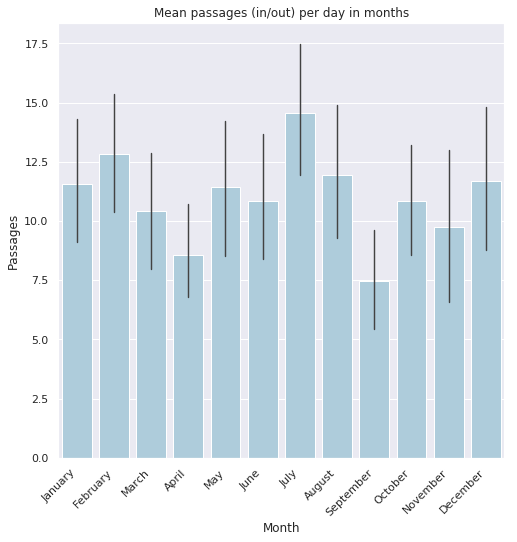

In [57]:
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(x='proper_month', 
            y='passage', 
            data=month_sum_true.sort_values(by='month'),
            ci=95, 
            palette=[palette[0]])
ax.set_xlabel('Month')
ax.set_ylabel('Passages')
ax.set_title('Mean passages (in/out) per day in months')
labels = ax.xaxis.get_majorticklabels() 
_=ax.set_xticklabels(labels, rotation=45, ha='right', minor=False)

In [58]:
year_dfs = [
    month_sum_true[month_sum_true.year == '2015'],
    month_sum_true[month_sum_true.year == '2016'],
    month_sum_true[month_sum_true.year == '2017'],
    month_sum_true[month_sum_true.year == '2018']
]

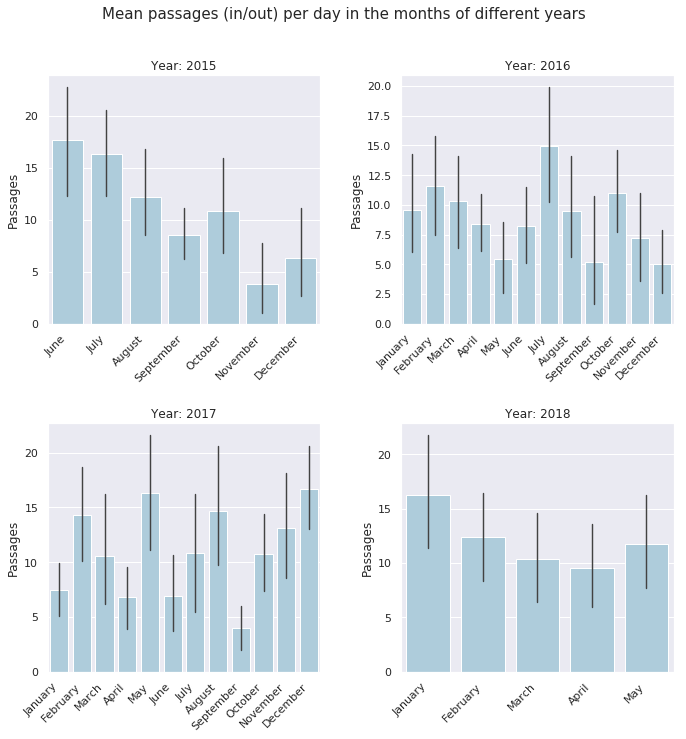

In [59]:
fig, axes = plt.subplots(2,2, figsize=(10,10))
axes = axes.flatten()
fig.suptitle(
    'Mean passages (in/out) per day in the months of different years',
    fontsize=15,
    y=1.04
)
for ax, y_df in zip(axes, year_dfs):
    sns.barplot(x='proper_month', 
            y='passage', 
            data=y_df.sort_values(by='month'),
            ci=95, 
            palette=[palette[0]],
            ax=ax)
    this_year = y_df['year'].unique()[0]
    ax.set_xlabel('')
    ax.set_ylabel('Passages')
    ax.set_title(
        f'Year: {this_year}')
    labels = ax.xaxis.get_majorticklabels() 
    ax.set_xticklabels(labels, rotation=45, ha='right', minor=False)
    #ax.xaxis.set_tick_params(rotation=45)

plt.tight_layout()

### Vi kan även göra boxplots för att se distributionerna per månad för passager

### All directions

Text(0, 0.5, 'Passages')

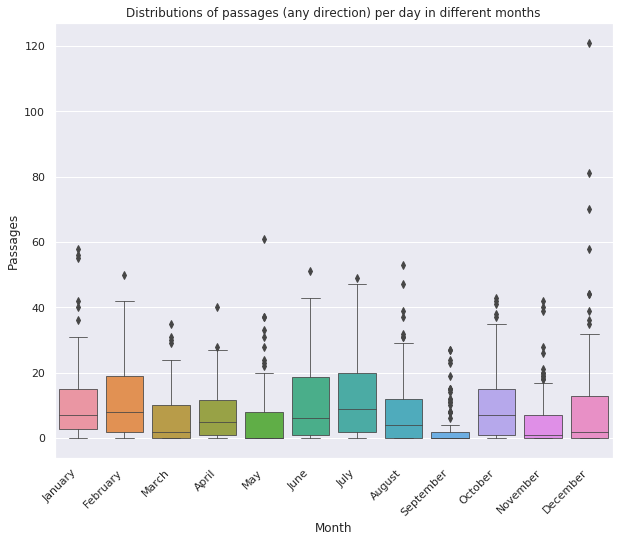

In [60]:
fig, ax = plt.subplots(1, figsize=(10,8))
sns.boxplot(x='proper_month', 
            y='passage',
            data=month_sum.sort_values(by='month'), 
            ax=ax)
labels = ax.xaxis.get_majorticklabels() 
_=ax.set_xticklabels(labels, rotation=45, ha='right', minor=False)
ax.set_title('Distributions of passages (any direction) per day in different months')
ax.set_xlabel('Month')
ax.set_ylabel('Passages')

### Only true directions

Text(0, 0.5, 'Passages')

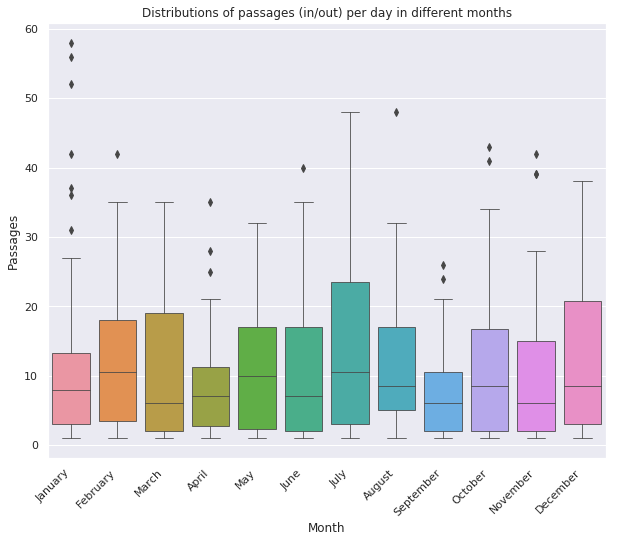

In [61]:
fig, ax = plt.subplots(1, figsize=(10,8))
sns.boxplot(x='proper_month', 
            y='passage',
            data=month_sum_true.sort_values(by='month'), 
            ax=ax)
labels = ax.xaxis.get_majorticklabels() 
_=ax.set_xticklabels(labels, rotation=45, ha='right', minor=False)
ax.set_title('Distributions of passages (in/out) per day in different months')
ax.set_xlabel('Month')
ax.set_ylabel('Passages')

### Split by in/out in boxplots

In [62]:
hax = month_sum_true.copy()

In [63]:
hax['direction'] = pd.Series()
hax.loc[hax.direction_numerical > 0, 'direction'] = 'in'
hax.loc[hax.direction_numerical == 0, 'direction'] = 'out'

Text(0, 0.5, 'Passages')

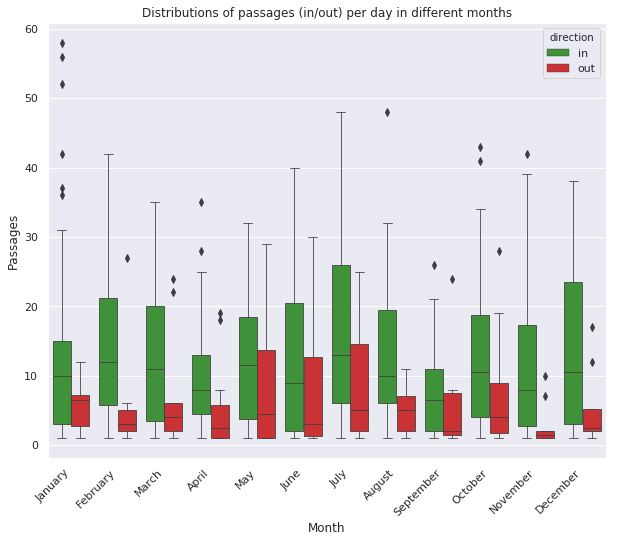

In [64]:
fig, ax = plt.subplots(1, figsize=(10,8))
sns.boxplot(x='proper_month', 
            y='passage',
            hue='direction',
            data=hax.sort_values(by='month'),
            palette=[p[3], p[5]],
            ax=ax)
labels = ax.xaxis.get_majorticklabels() 
_=ax.set_xticklabels(labels, rotation=45, ha='right', minor=False)
ax.set_title('Distributions of passages (in/out) per day in different months')
ax.set_xlabel('Month')
ax.set_ylabel('Passages')

### Vi kan även få alla observationer plottade

### All directions

Text(0, 0.5, 'Passages')

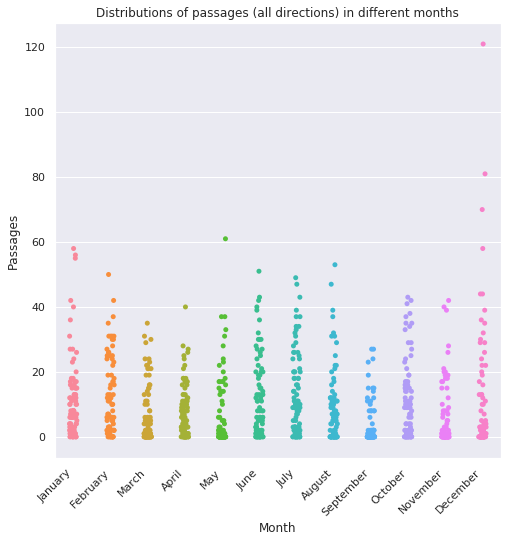

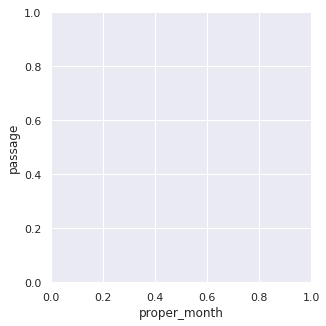

In [65]:
fig, ax = plt.subplots(1, figsize=(8,8))
sns.catplot(x='proper_month', 
            y='passage', 
            data=month_sum.sort_values(by='month'),
            ax=ax)
labels = ax.xaxis.get_majorticklabels() 
_=ax.set_xticklabels(labels, rotation=45, ha='right', minor=False)
ax.set_title('Distributions of passages (all directions) in different months')
ax.set_xlabel('Month')
ax.set_ylabel('Passages')

### Only in/out (true directions)

Text(0, 0.5, 'Passages')

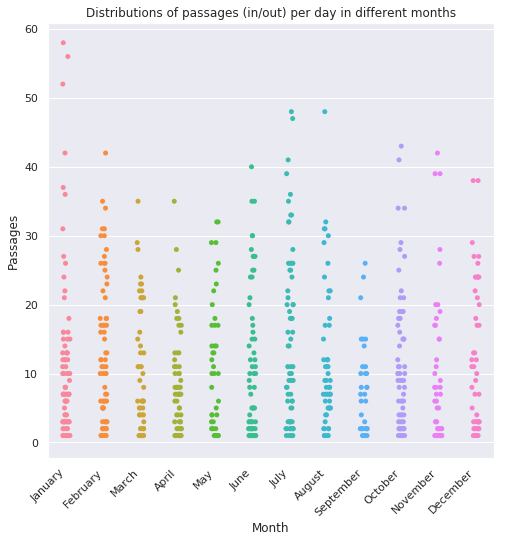

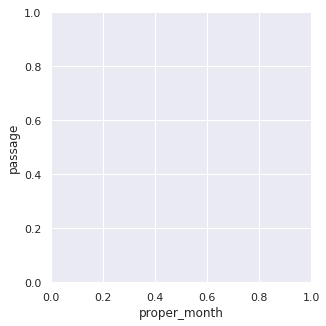

In [66]:
fig, ax = plt.subplots(1, figsize=(8,8))
sns.catplot(x='proper_month', 
            y='passage', 
            data=month_sum_true.sort_values(by='month'),
            ax=ax)
labels = ax.xaxis.get_majorticklabels() 
_=ax.set_xticklabels(labels, rotation=45, ha='right', minor=False)
ax.set_title('Distributions of passages (in/out) per day in different months')
ax.set_xlabel('Month')
ax.set_ylabel('Passages')

### Split by in/out direction

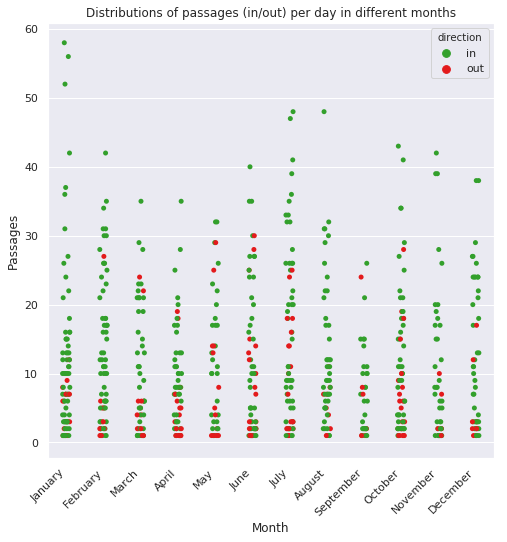

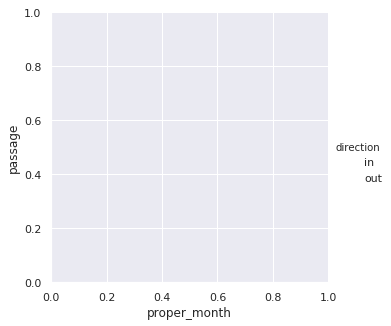

In [67]:
fig, ax = plt.subplots(1, figsize=(8,8))
sns.catplot(x='proper_month', 
            y='passage',
            hue='direction',
            data=hax.sort_values(by='month'),
            palette=[p[3], p[5]],
            ax=ax)
labels = ax.xaxis.get_majorticklabels() 
_=ax.set_xticklabels(labels, rotation=45, ha='right', minor=False)
ax.set_title('Distributions of passages (in/out) per day in different months')
ax.set_xlabel('Month')
ax.set_ylabel('Passages')
plt.show()

### Vi kan även plotta alla datapunkter direkt, och titta på konfidensintervall runt mean estimates för varje månad

In [68]:
import datetime

In [69]:
# already sorted by date, nice
all(month_sum['date'] == sorted(month_sum['date']))

True

In [70]:
ts = [datetime.date(t.year, t.month, t.day) for t in month_sum['date']]
ys = [p for p in month_sum['passage']]

In [71]:
d = pd.DataFrame({'t': ts, 'Passages': ys})
d['Month'] = d['t'].apply(lambda t: t.strftime('%Y-%m'))

#### Alla dina datapunkter plottade, finns en riktig outlier där runt 2018-01

Text(0, 0.5, 'Passages')

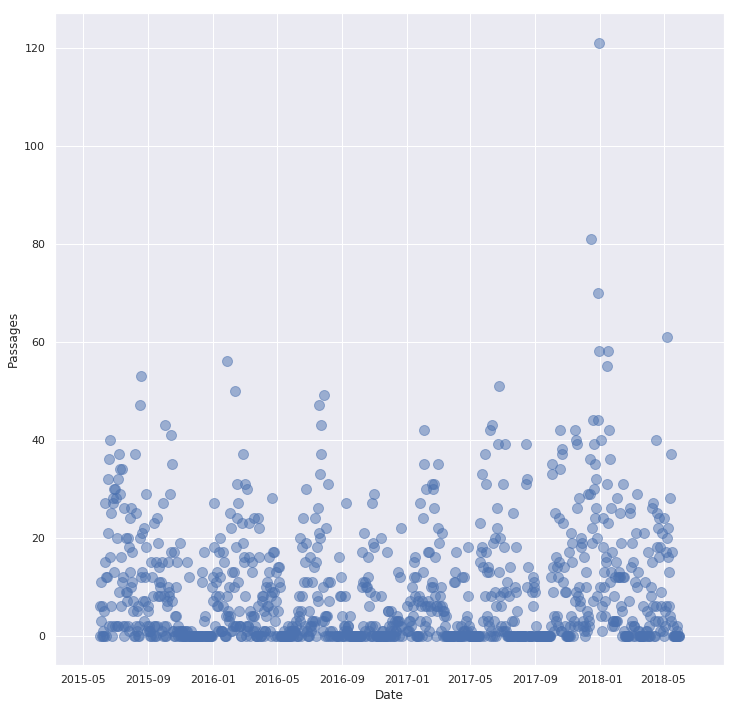

In [72]:
fig, ax = plt.subplots(1, figsize=(12,12))
plt.scatter(ts, ys, alpha=0.5, s=100)
plt.xlabel('Date')
plt.ylabel('Passages')

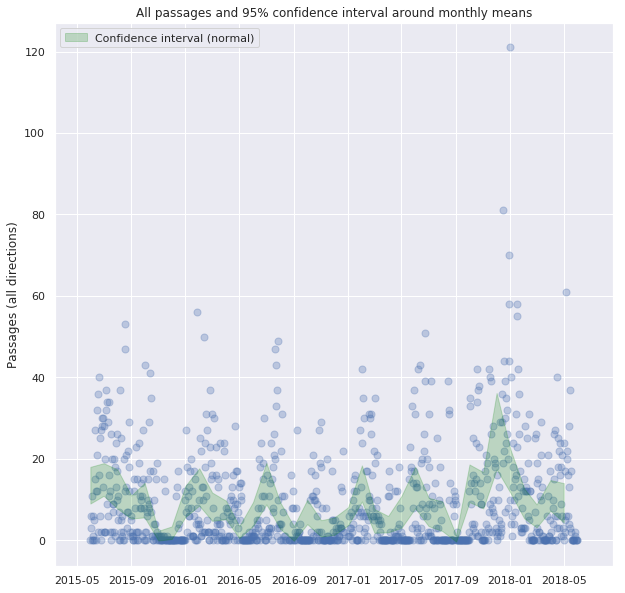

In [73]:
def plot_confidence_interval(observations_by_group):
    groups = list(sorted(observations_by_group.keys()))
    lo_bound = []
    hi_bound = []
    for group in groups:
        series = observations_by_group[group]
        mu, std, n = np.mean(series), np.std(series), len(series)
        lo_bound.append(mu - 1.96*std*n**-0.5)
        hi_bound.append(mu + 1.96*std*n**-0.5)
    plt.fill_between(groups, 
                     lo_bound, 
                     hi_bound, 
                     alpha=0.2,
                     label='Confidence interval (normal)',
                     color='green')

plt.figure(figsize=(10,10))
plt.scatter(ts, ys, alpha=0.3, s=50)
observations_by_month = {}
for month, y in zip(d['Month'], d['Passages']):
    observations_by_month.setdefault(month, []).append(y)
plot_confidence_interval(observations_by_month)
plt.ylabel('Passages (all directions)')
plt.title('All passages and 95% confidence interval around monthly means')
plt.legend(loc='upper left')

### Same plot with only true (in/out) directions

In [74]:
ts = [datetime.date(t.year, t.month, t.day) for t in month_sum_true['date']]
ys = [p for p in month_sum_true['passage']]

d = pd.DataFrame({'t': ts, 'Passages': ys})
d['Month'] = d['t'].apply(lambda t: t.strftime('%Y-%m'))

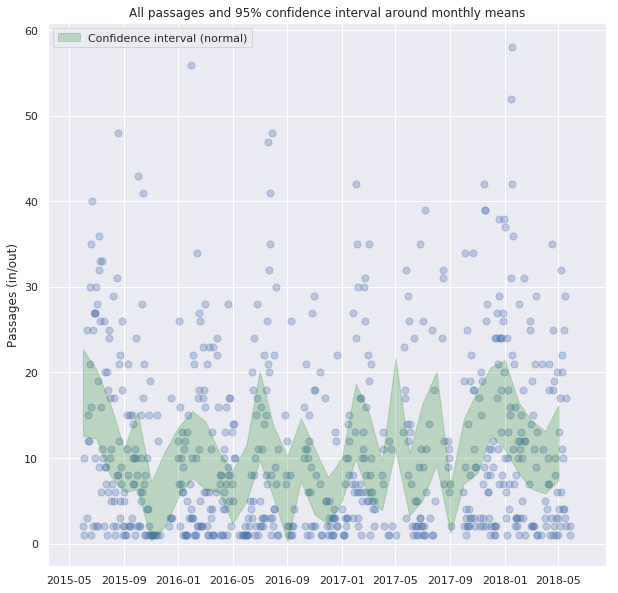

In [75]:
def plot_confidence_interval(observations_by_group):
    groups = list(sorted(observations_by_group.keys()))
    lo_bound = []
    hi_bound = []
    for group in groups:
        series = observations_by_group[group]
        mu, std, n = np.mean(series), np.std(series), len(series)
        lo_bound.append(mu - 1.96*std*n**-0.5)
        hi_bound.append(mu + 1.96*std*n**-0.5)
    plt.fill_between(groups, 
                     lo_bound, 
                     hi_bound, 
                     alpha=0.2,
                     label='Confidence interval (normal)',
                     color='green')

plt.figure(figsize=(10,10))
plt.scatter(ts, ys, alpha=0.3, s=50)
observations_by_month = {}
for month, y in zip(d['Month'], d['Passages']):
    observations_by_month.setdefault(month, []).append(y)
plot_confidence_interval(observations_by_month)
plt.ylabel('Passages (in/out)')
plt.title('All passages and 95% confidence interval around monthly means')
plt.legend(loc='upper left')

### Man kan även göra en heatmap över passager per månad och timme

In [76]:
hour_month = df_drop.groupby(['month', 'hour'], sort=False).sum()['passage'].reset_index()

In [77]:
hour_month.head()

,month,hour,passage
0,06,9,27
1,06,10,59
2,06,20,34
3,06,23,22
4,06,2,20


In [78]:
pivoted = hour_month.pivot('hour', 'month', 'passage')

In [79]:
pivoted.fillna(0, inplace=True)

In [80]:
piv2 = pivoted.sort_values(by='hour', ascending=False)

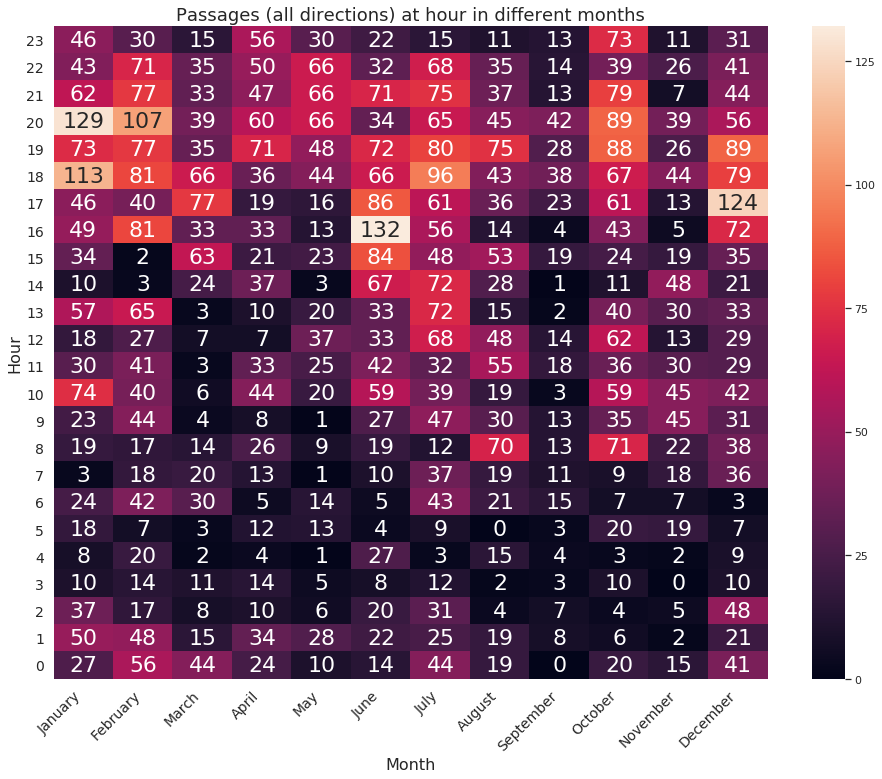

In [81]:
fig, ax = plt.subplots(figsize=(16,12))
sns.heatmap(piv2, ax=ax, annot=True, fmt='g')
ax.set_xlabel('Month', fontsize=16)
ax.set_ylabel('Hour', fontsize=16)
ax.set_title('Passages (all directions) at hour in different months', fontsize=18)
ax.set_xticklabels(
    ['January','February','March','April','May',
     'June','July','August','September','October',
     'November','December']
)
xlabels = ax.xaxis.get_majorticklabels() 
_=ax.set_xticklabels(xlabels, 
                     rotation=45, 
                     ha='right',
                     fontsize=14,
                     minor=False)
ylabels = ax.yaxis.get_majorticklabels() 
_=ax.set_yticklabels(ylabels, 
                     rotation=0, 
                     ha='right',
                     fontsize=14,
                     minor=False)

## Only in/out in heatmap

In [82]:
hour_month_true = df_only_true.groupby(['month', 'hour'], sort=False).sum()['passage'].reset_index()
pivoted_true = hour_month_true.pivot('hour', 'month', 'passage')

In [83]:
piv_true = pivoted_true.sort_values(by='hour', ascending=False)

In [84]:
piv_true.fillna(0, inplace=True)

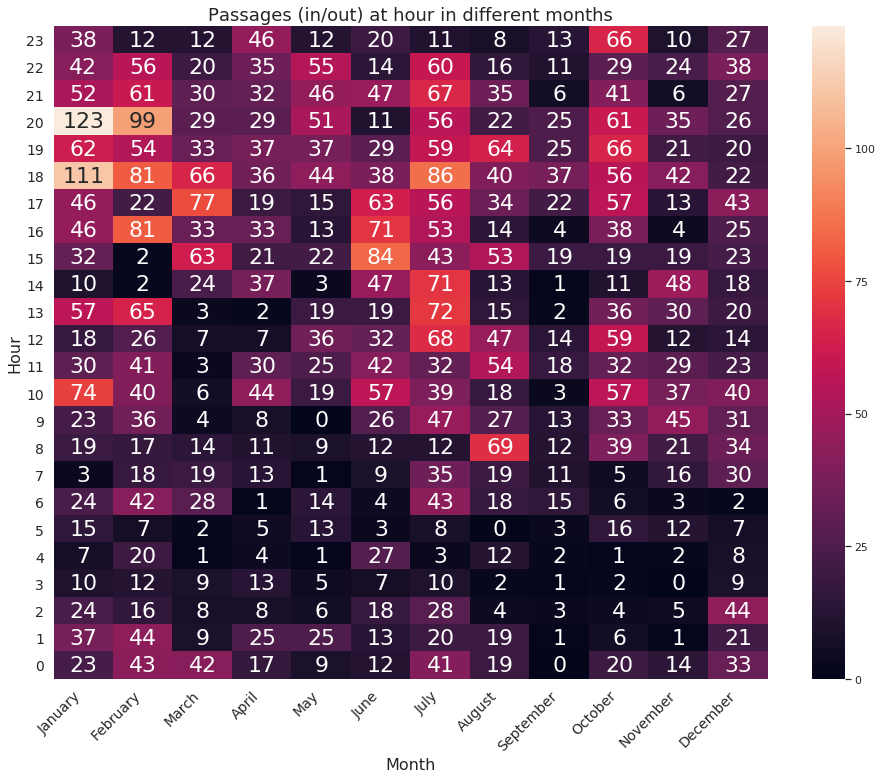

In [85]:
fig, ax = plt.subplots(figsize=(16,12))
sns.heatmap(piv_true, ax=ax, annot=True, fmt='g')
ax.set_xlabel('Month', fontsize=16)
ax.set_ylabel('Hour', fontsize=16)
ax.set_title('Passages (in/out) at hour in different months', fontsize=18)
ax.set_xticklabels(
    ['January','February','March','April','May',
     'June','July','August','September','October',
     'November','December']
)
xlabels = ax.xaxis.get_majorticklabels() 
_=ax.set_xticklabels(xlabels, 
                     rotation=45, 
                     ha='right',
                     fontsize=14,
                     minor=False)
ylabels = ax.yaxis.get_majorticklabels() 
_=ax.set_yticklabels(ylabels, 
                     rotation=0, 
                     ha='right',
                     fontsize=14,
                     minor=False)

## Passager per gruppstorlek

#### Total number of passages sorted by group size

In [86]:
g_size = df_drop.groupby('group size').sum().reset_index()

Text(0, 0.5, 'Passages (any direction)')

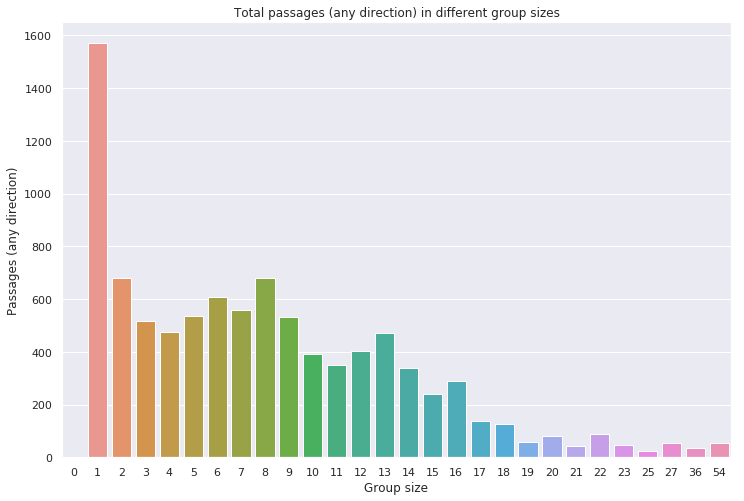

In [105]:
fig, ax = plt.subplots(1, figsize=(12,8))
sns.barplot(x='group size', 
            y='passage', 
            data=g_size,
            ax=ax)
ax.set_title('Total passages (any direction) in different group sizes')
ax.set_xlabel('Group size')
ax.set_ylabel('Passages (any direction)')

### Only in/out

In [88]:
g_size_true = df_only_true.groupby('group size').sum().reset_index()

Text(0, 0.5, 'Passages (in/out)')

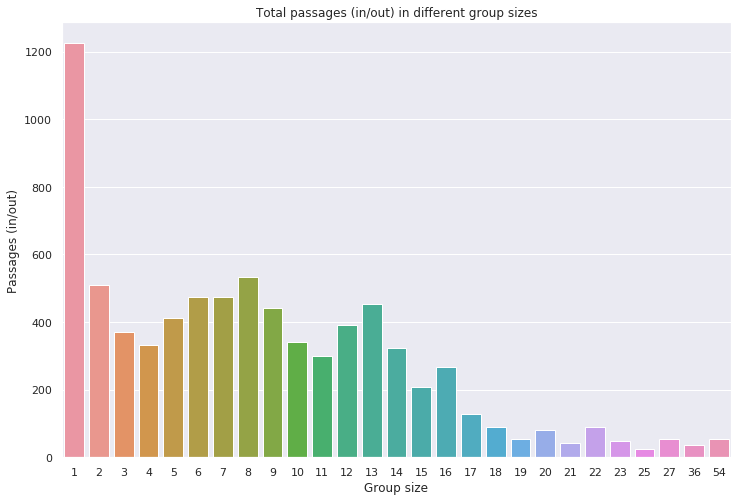

In [106]:
fig, ax = plt.subplots(1, figsize=(12,8))
sns.barplot(x='group size', 
            y='passage', 
            data=g_size_true,
            ax=ax)
ax.set_title('Total passages (in/out) in different group sizes')
ax.set_xlabel('Group size')
ax.set_ylabel('Passages (in/out)')

##### Knappt så man ser nån skillnad mellan in/out och andra (de är dock annorlunda, se grupp 17+18 t.ex)..

## Mean group size?


In [90]:
print('mean group size all directions: {}'
      .format(df_drop['group size'].mean()))

mean group size all directions: 7.810877373011801


In [91]:
print('mean group size in/out directions: {}'
      .format(df_only_true['group size'].mean()))

mean group size in/out directions: 8.643427835051547


## Passager per kön

### Total number of passages sorted by sex (male/female/unknown)

In [92]:
# drop passage == '*' vi kan inte summera '*', måste vara siffror
df_drop = df[df.passage != '*']
df_drop.loc[:, 'passage'] = df_drop['passage'].astype(int)

In [93]:
df_drop.loc[:, 'sex'] = df_drop['sex'].str.lower()
df_drop.loc[df_drop.sex == 'u ', 'sex'] = 'u'

In [94]:
sex_all = df_drop.groupby('sex').sum().reset_index()

Text(0, 0.5, 'Passages (all directions)')

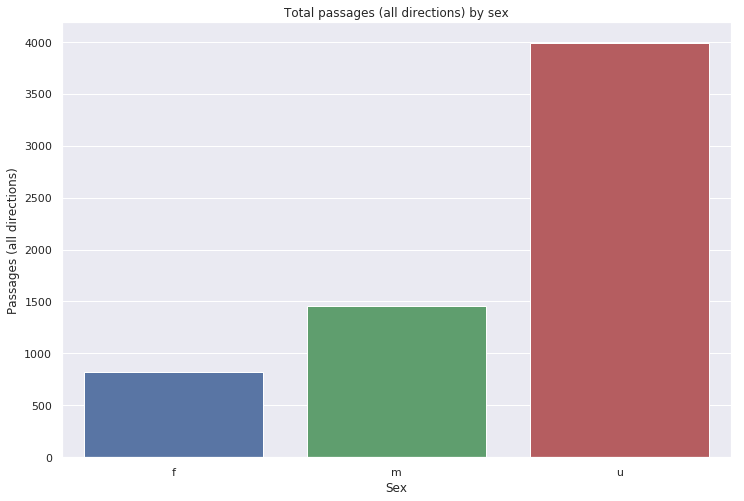

In [103]:
fig, ax = plt.subplots(1, figsize=(12,8))
sns.barplot(x='sex', 
            y='passage', 
            data=sex_all,
            ax=ax)
ax.set_title('Total passages (all directions) by sex')
ax.set_xlabel('Sex')
ax.set_ylabel('Passages (all directions)')

In [96]:
df_only_true.loc[:, 'sex'] = df_only_true['sex'].str.lower()
df_only_true.loc[df_only_true.sex == 'u ', 'sex'] = 'u'

In [97]:
sex_true = df_only_true.groupby('sex').sum().reset_index()

Text(0, 0.5, 'Passages (in/out)')

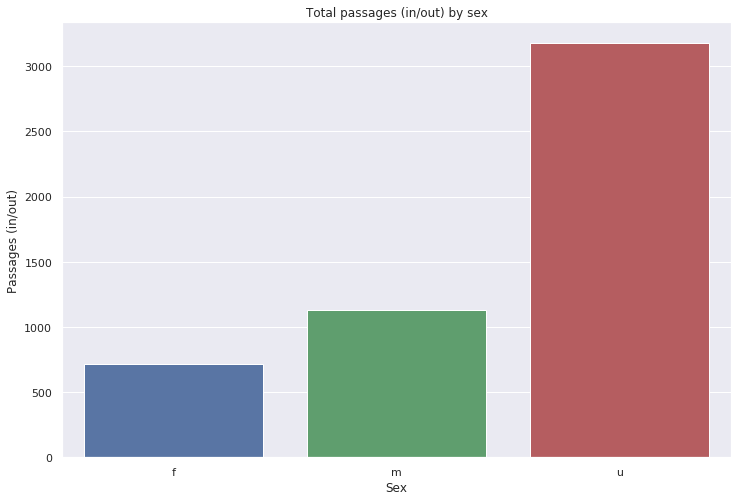

In [104]:
fig, ax = plt.subplots(1, figsize=(12,8))
sns.barplot(x='sex', 
            y='passage', 
            data=sex_true,
            ax=ax)
ax.set_title('Total passages (in/out) by sex')
ax.set_xlabel('Sex')
ax.set_ylabel('Passages (in/out)')

#### Out of all total number of passages, Passage (1/0/*) = 1, done by single individuals, Group size = 1, how many percent are male, female or unknown?

In [99]:
df_drop.sex.unique()

array([nan, 'u', 'm', 'f'], dtype=object)

In [100]:
valid_sex = ['u', 'm', 'f']

In [101]:
all_sex = df_drop[(df_drop.passage == 1) & 
                  (df_drop['group size'] == 1) &
                  (df_drop.sex.isin(valid_sex))]
male = all_sex[all_sex.sex == 'm']
female = all_sex[all_sex.sex == 'f']
unk = all_sex[all_sex.sex == 'u']

In [102]:
print('percentage male {:.3f}%'
      .format(len(male.index) / len(all_sex.index)))

print('percentage female {:.3f}%'
      .format(len(female.index) / len(all_sex.index)))

print('percentage unknown {:.3f}%'
      .format(len(unk.index) / len(all_sex.index)))

percentage male 0.642%
percentage female 0.017%
percentage unknown 0.342%


### Passager per månfas

TODO.

Moon phase är indelad i 1-8 där fullmåne är 5. Finns förklarat under ”methods” i arbetet.
o Total number of passages taking place at night sorted per moon phase
Dvs. Av totala antalet passager i alla riktningar och som sker mellan kl 19:00 och 07:00, hur är
dessa fördelade per månfas?
o Total number of true passages taking place at night sorted per moon phase
Dvs. Av antalet passager som sker in resp out och som sker mellan kl 19:00 och 07:00, hur är
dessa fördelade per månfas?
- Övrigt
o Ökade användandet av korridor 1 och 2 efter 25 april 2017 jämför med tidigare? (Då stängde
man korridor 3 permanent.)